# Import the essential libraries

In [2]:
!pip install tensorflow



In [3]:
# Essential and common packages
import os
import glob

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the ResNet50 model
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D,
    BatchNormalization, Flatten, Conv2D, AveragePooling2D,
    MaxPooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.initializers import glorot_uniform,random_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
from sklearn.metrics import confusion_matrix

# For visualization of plots without plt.show() (only for Jupyter Notebook)
# Uncomment if running in a Jupyter Notebook
# %matplotlib inline


# Define the required variable

In [5]:
dataset_url = r'C:\Users\trina\Downloads\EuroSAT (1)\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

# Data preparation for the model

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [8]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [9]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


# Visualization of input datasets

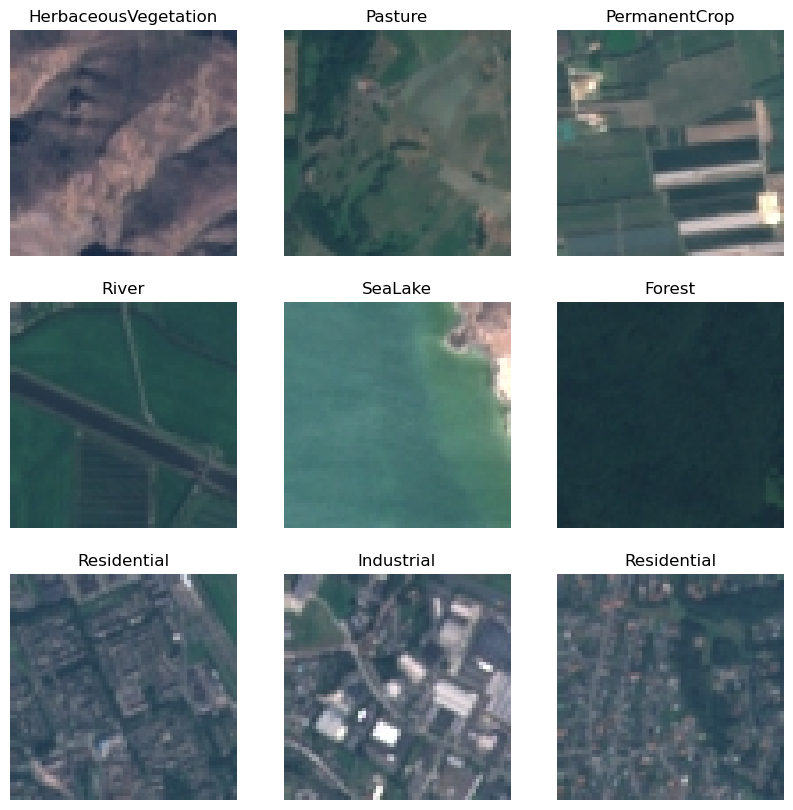

In [11]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

In [13]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    
    
    # R_Filters
    F1, F2, F3 = filters
    
    # inpuit value.
    X_shortcut = X
    cache = []
    # 1 component
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X)
    
    # 2component
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # 3 component
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # last and final 
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [14]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):    
    # Filter
    F1, F2, F3 = filters
    
    # Save the i_value
    X_shortcut = X


    #the main path#
    
    # First component
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third components)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    #shhort cut
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final add main to shortcut and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [15]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
  
    X_input = Input(input_shape)

    
    # 0 padding 
    X = ZeroPadding2D((3, 3))(X_input)
    
    # 1th_s
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 2th_s
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # 3th_s
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # 4th_s 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # 5th_s
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # avvgpool
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output_layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    #model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [17]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=40, batch_size=32)

C:\Users\trina\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 434s 602ms/step - accuracy: 0.4176 - loss: 1.9822 - val_accuracy: 0.4706 - val_loss: 1.8964
Epoch 2/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 306s 453ms/step - accuracy: 0.6718 - loss: 0.9917 - val_accuracy: 0.2941 - val_loss: 5.6256
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 303s 449ms/step - accuracy: 0.6910 - loss: 0.9620 - val_accuracy: 0.5274 - val_loss: 1.6764
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 301s 445ms/step - accuracy: 0.7514 - loss: 0.7481 - val_accuracy: 0.4683 - val_loss: 4.3703
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 299s 443ms/step - accuracy: 0.7748 - loss: 0.7019 - val_accuracy: 0.5083 - val_loss: 22.1090
Epoch 6/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 305s 452ms/step - accuracy: 0.8012 - loss: 0.6376 - val_accuracy: 0.6424 - val_loss: 1.1824
Epoch 7/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 303s 448ms/step - accuracy: 0.8076 - loss: 0.5899 - val_accuracy: 0.5759 - val_loss: 1.8470
Epoch 8/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 304s 450ms/step - accuracy: 0.8268 

# analyzing results and visualization

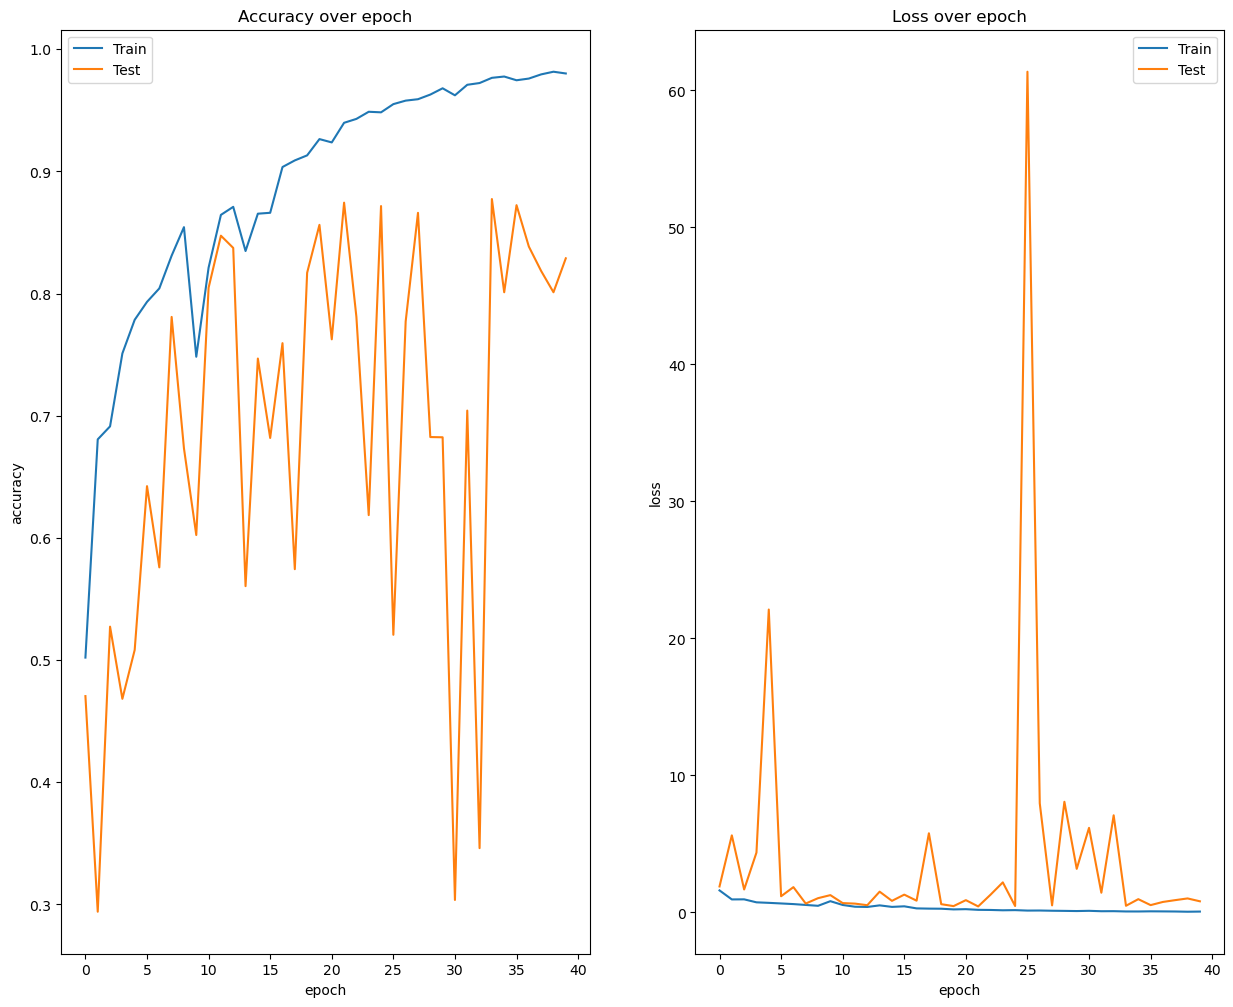

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [28]:
y_pred = []  #predicteed labels
y_true = []  #truee labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat

    y_true.append(label_batch)
    
    preds = model.predict(image_batch)
   
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted i9nto tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [30]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 891,    4,   32,    2,    0,   62,   53,    0,   17,   21],
       [   2, 1020,    4,    0,    0,   33,    0,    0,    8,   22],
       [   5,   20,  977,    2,    0,   23,   32,    0,   11,    5],
       [  10,    0,   67,  687,   30,   42,   12,    6,   31,    0],
       [   0,    0,   55,   13,  790,    2,    0,    8,    2,    0],
       [   6,    6,   22,    0,    0,  672,    0,    0,    0,    2],
       [  20,    0,  232,    4,   10,   99,  497,    2,   18,    0],
       [   0,    0,  391,    6,   26,    7,    2,  629,    2,    0],
       [  28,   12,   16,   21,    4,   87,    0,    0,  731,    2],
       [   3,    4,    0,    0,    0,    8,    0,    0,    0, 1054]],
      dtype=int64)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import itertools 
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 891    4   32    2    0   62   53    0   17   21]
 [   2 1020    4    0    0   33    0    0    8   22]
 [   5   20  977    2    0   23   32    0   11    5]
 [  10    0   67  687   30   42   12    6   31    0]
 [   0    0   55   13  790    2    0    8    2    0]
 [   6    6   22    0    0  672    0    0    0    2]
 [  20    0  232    4   10   99  497    2   18    0]
 [   0    0  391    6   26    7    2  629    2    0]
 [  28   12   16   21    4   87    0    0  731    2]
 [   3    4    0    0    0    8    0    0    0 1054]]


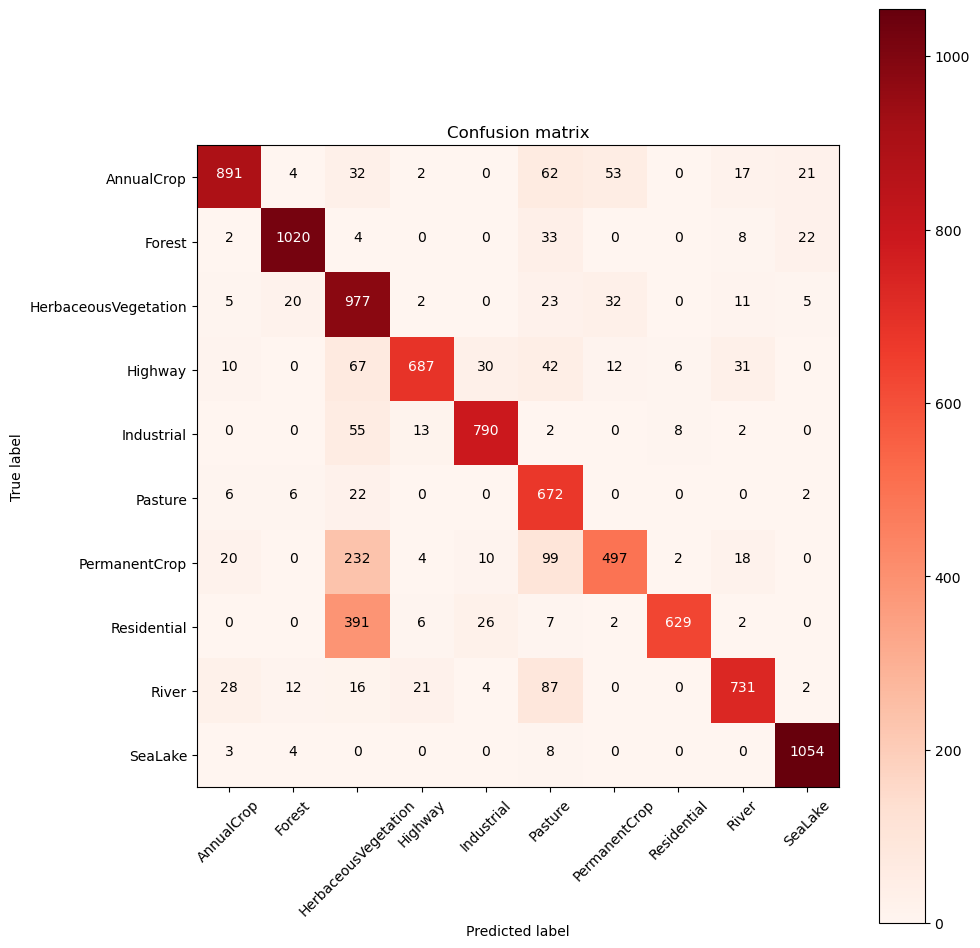

In [34]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')